In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import m_e, e ,c 
from astropy import units as u
from scipy.constants import physical_constants

In [48]:
C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

f_CIV_K = 0.190
f_CIV_H = 0.0952
K_gamma = 2.65e+8
H_gamma = 2.64e+8
NN = int(1e4)
xx = np.linspace(-10, 10, NN)
yy = np.linspace(-20,20, NN)

rr = np.arange(12, 19, 1, dtype=np.float128)
atom = [13,20,32,50,79]


total_N_c = np.outer(10**rr, atom) / 10
total_N_c = total_N_c.flatten()

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)


def tau(sig_c, x):
    return sig_c * x

def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def total_tau(v_th,C_IV):
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV)
    tau_profile = tau(sig_c, total_N_c[:, None]) * Voigt_profile
    return tau_profile


def scatter_cross_section(v_th):
    # m_e = m_e.to(u.g) # cm
    cc = c.to(u.cm/u.s).value
    r_e = physical_constants["classical electron radius"][0]*1e2 # cm
    f_total = f_CIV_K + f_CIV_H
    del_D_K = v_th/C_IV_K
    del_D_H = v_th / C_IV_H 
    Voigt_H = Voigt(xx,v_th,H_gamma, C_IV_H)
    Voigt_K = Voigt(xx,v_th,K_gamma, C_IV_K)
    result = (np.sqrt(np.pi) / f_total) * (r_e)*cc* ((f_CIV_K/del_D_K )*Voigt_H +(f_CIV_H/del_D_H )*Voigt_K  )
    return result




8.068033119843106e-14


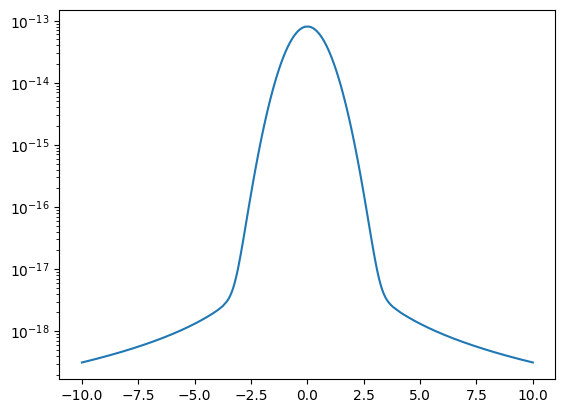

In [49]:
cross_section = scatter_cross_section(v_th_CIV)
plt.plot(xx,cross_section)
print(cross_section.max())
plt.yscale('log')

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 [Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$')])

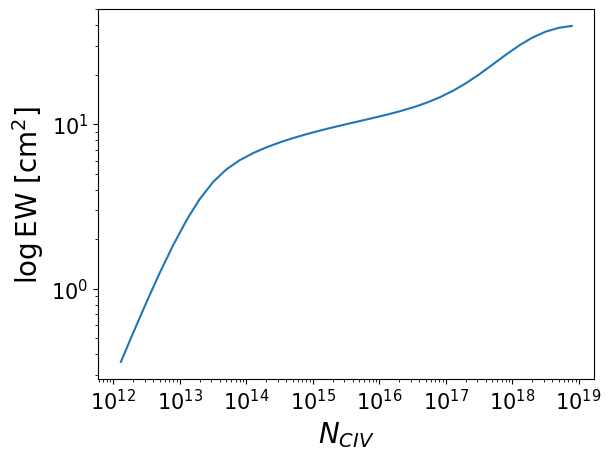

In [50]:

dx = xx[1] - xx[0]
EW = np.zeros(len(total_N_c))
for ii,column_density in enumerate(total_N_c):
    tau_cc = cross_section * column_density

    EW[ii] = 2*np.sum(1-np.exp(-tau_cc))*dx

plt.loglog(total_N_c,EW,'-')

plt.xlabel(r'$N_{CIV}$',fontsize=20)
plt.ylabel(r'$\log{\rm EW}$ $[\rm cm^2]$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

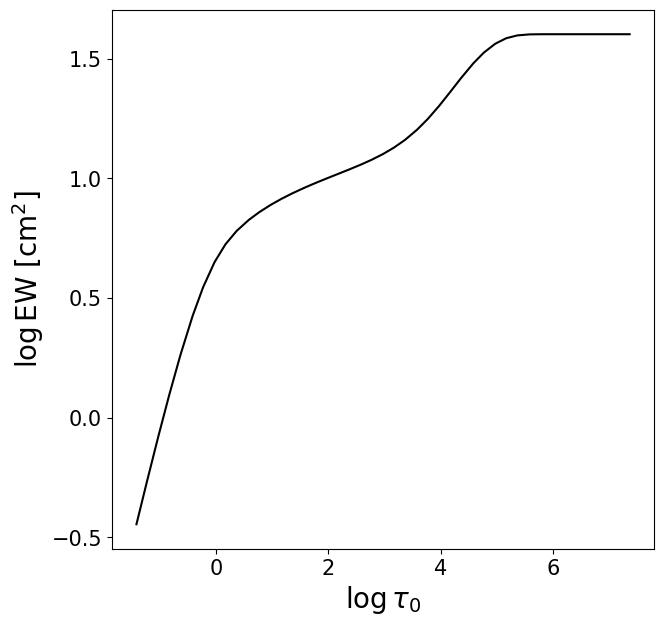

In [47]:
plt.figure(1,figsize=(7,7))
tau_change = sig_c*total_N_c 

plt.plot(np.log10(tau_change),np.log10(EW),'k-')

plt.xlabel(r'$\log{\tau_0}$',fontsize=20)
plt.ylabel(r'$\log{\rm EW}$ $[\rm cm^2]$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)